# Métricas de Grafos
Implementación de métricas globales y locales mostradas en las imágenes.

In [47]:
import sys
import subprocess
import pkgutil
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community.community_louvain as community_louvain
from collections import Counter


In [48]:
plt.rcParams["figure.figsize"] = (8,5)


In [49]:
# Función auxiliar de dibujo
def draw_graph(G, node_size=None, node_color=None, title=None, pos=None, with_labels=False, cmap=plt.cm.tab10):
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    if node_size is None:
        node_size = [300 for _ in G.nodes()]
    if node_color is None:
        node_color = "lightgray"
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=cmap)
    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(title or "")
    plt.axis("off")
    return pos


In [50]:
# Crear grafos de ejemplo
G_karate = nx.karate_club_graph()  # grafo clásico de ejemplo
G_ws = nx.watts_strogatz_graph(n=30, k=4, p=0.1, seed=1)  # small-world
G_rand = nx.erdos_renyi_graph(n=30, p=0.12, seed=2)  # aleatorio
G_reg = nx.cycle_graph(20)  # grafo regular (ciclo)


/usr/local/lib/python3.12/dist-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


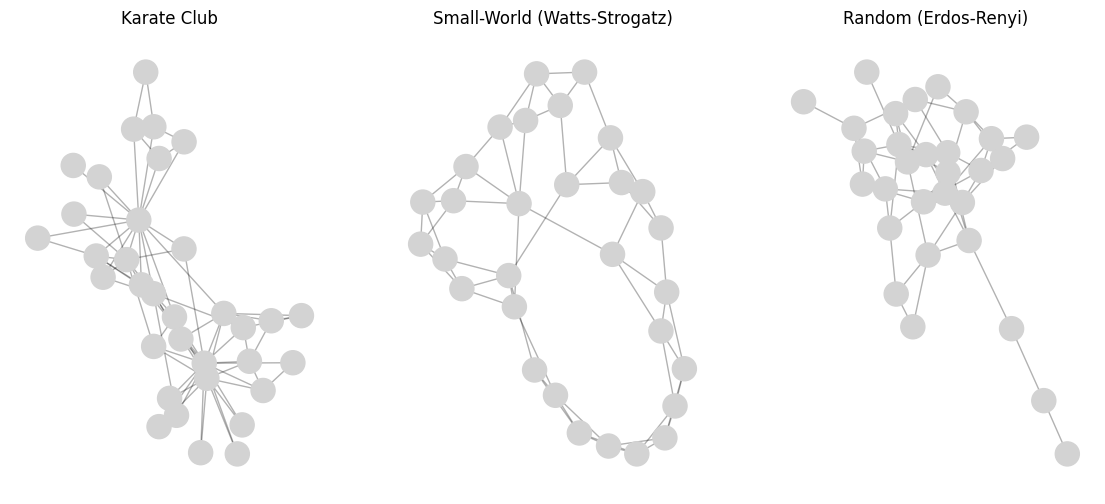

In [51]:
# Visualizamos los grafos de ejemplo
plt.figure(figsize=(14,6))
plt.subplot(1,3,1); draw_graph(G_karate, title="Karate Club")
plt.subplot(1,3,2); draw_graph(G_ws, title="Small-World (Watts-Strogatz)")
plt.subplot(1,3,3); draw_graph(G_rand, title="Random (Erdos-Renyi)")
plt.show()


In [52]:
# Longitud promedio del camino más corto y diámetro
def global_shortest_path_metrics(G):
    if nx.is_connected(G):
        avg_shortest = nx.average_shortest_path_length(G)
        diam = nx.diameter(G)
        print("Average shortest path length:", avg_shortest)
        print("Diameter:", diam)
    else:
        # aplicable por componente conectada
        comps = list(nx.connected_components(G))
        print("Grafo no conectado. Computando por componente (tamaño, avg_shortest, diameter):")
        for comp in comps:
            sub = G.subgraph(comp)
            if sub.number_of_nodes() > 1:
                print(len(sub), nx.average_shortest_path_length(sub), nx.diameter(sub))
            else:
                print(len(sub), "singleton")

print("Karate:")
global_shortest_path_metrics(G_karate)
print("\nSmall-world:")
global_shortest_path_metrics(G_ws)
print("\nRandom:")
global_shortest_path_metrics(G_rand)


Karate:
Average shortest path length: 2.408199643493761
Diameter: 5

Small-world:
Average shortest path length: 3.0781609195402297
Diameter: 6

Random:
Average shortest path length: 2.7655172413793103
Diameter: 7


In [53]:
# Coeficiente de agrupamiento (clustering)
for name, G in [("Karate", G_karate), ("Small-World", G_ws), ("Random", G_rand), ("Regular cycle", G_reg)]:
    avg_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)  # otra medida relacionada
    print(f"{name}: average_clustering={avg_clustering:.4f}, transitivity={transitivity:.4f}")


Karate: average_clustering=0.5706, transitivity=0.2557
Small-World: average_clustering=0.4022, transitivity=0.3913
Random: average_clustering=0.1538, transitivity=0.1071
Regular cycle: average_clustering=0.0000, transitivity=0.0000


Karate modularity: 0.44490358126721763
Communities (sizes): {0: 11, 1: 5, 3: 12, 2: 6}


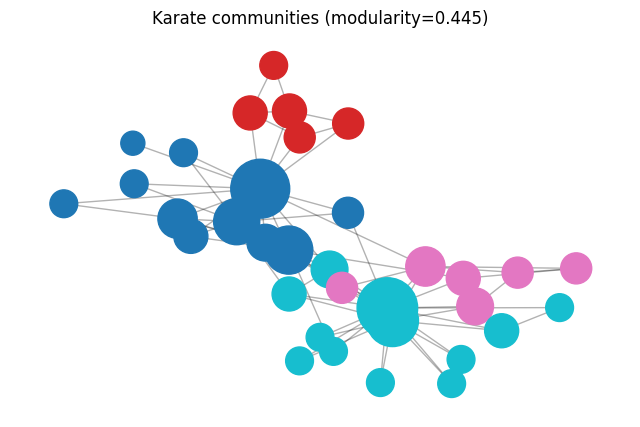

In [54]:
# Modularidad: detección de comunidades con Louvain + modularidad
def detect_communities_and_modularity(G):
    partition = community_louvain.best_partition(G)  # dict: node -> community
    modularity = community_louvain.modularity(partition, G)
    # organizar por comunidades
    communities = {}
    for node, com in partition.items():
        communities.setdefault(com, []).append(node)
    return partition, communities, modularity

partition, communities, mod = detect_communities_and_modularity(G_karate)
print("Karate modularity:", mod)
print("Communities (sizes):", {k: len(v) for k,v in communities.items()})
# Dibujar coloreado por comunidad
colors = [partition[n] for n in G_karate.nodes()]
draw_graph(G_karate, node_color=colors, node_size=[200+100*nx.degree(G_karate,n) for n in G_karate.nodes()],
           title=f"Karate communities (modularity={mod:.3f})")
plt.show()


In [55]:
# Asortatividad por grado (assortative / disassortative)
for name, G in [("Karate", G_karate), ("Small-World", G_ws), ("Random", G_rand)]:
    assort = nx.degree_assortativity_coefficient(G)
    print(f"{name}: degree assortativity = {assort:.4f} "
          f"({'assortative' if assort>0 else 'disassortative' if assort<0 else 'neutral'})")


Karate: degree assortativity = -0.4756 (disassortative)
Small-World: degree assortativity = -0.0676 (disassortative)
Random: degree assortativity = -0.1593 (disassortative)


In [56]:
# Betweenness, Degree, Closeness, PageRank, Eigenvector
G = G_karate  # usar el karate como demo
betw = nx.betweenness_centrality(G, normalized=True)
deg = nx.degree_centrality(G)  # grado normalizado por n-1
clos = nx.closeness_centrality(G)
pr = nx.pagerank(G, alpha=0.85)
try:
    eig = nx.eigenvector_centrality(G, max_iter=500)
except nx.PowerIterationFailedConvergence:
    eig = nx.eigenvector_centrality_numpy(G)  # alternativa

# Mostrar top 5 de cada centralidad
def top_k(d, k=5):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

print("Top betweenness:", top_k(betw))
print("Top degree:", top_k(deg))
print("Top closeness:", top_k(clos))
print("Top pagerank:", top_k(pr))
print("Top eigenvector:", top_k(eig))


Top betweenness: [(0, 0.43763528138528146), (33, 0.30407497594997596), (32, 0.145247113997114), (2, 0.14365680615680618), (31, 0.13827561327561325)]
Top degree: [(33, 0.5151515151515151), (0, 0.48484848484848486), (32, 0.36363636363636365), (2, 0.30303030303030304), (1, 0.2727272727272727)]
Top closeness: [(0, 0.5689655172413793), (2, 0.559322033898305), (33, 0.55), (31, 0.5409836065573771), (8, 0.515625)]
Top pagerank: [(33, 0.09698041880501741), (0, 0.08850807396280012), (32, 0.07592643687005646), (2, 0.06276686454603017), (1, 0.057414840497110056)]
Top eigenvector: [(33, 0.37337121301323506), (0, 0.35548349418519426), (2, 0.3171893899684447), (32, 0.3086510477336959), (1, 0.2659538704545024)]


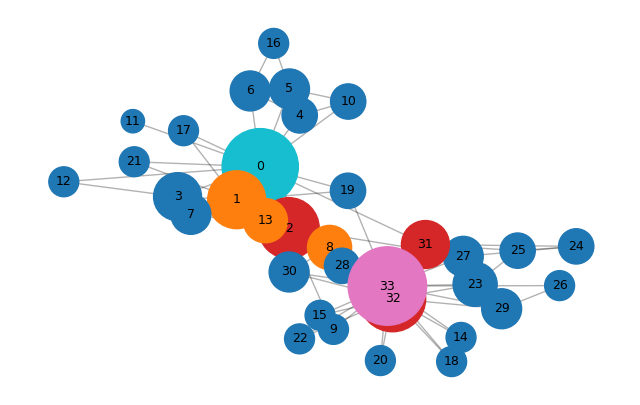

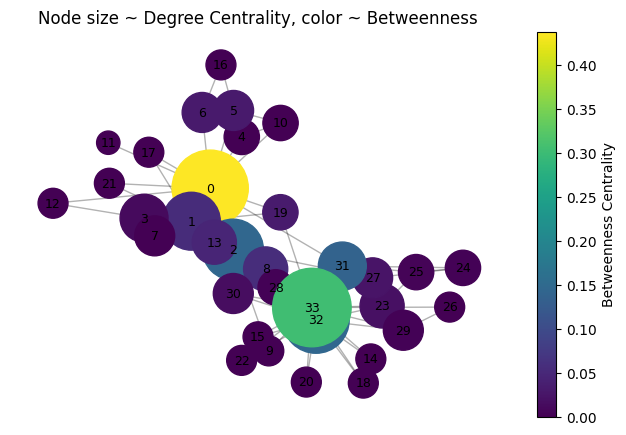

In [57]:
# Celda 11 — Visualización: tamaño = degree centrality * factor, color = betweenness
pos = nx.spring_layout(G, seed=42)
node_sizes = [6000 * deg[n] + 100 for n in G.nodes()]
node_colors = [betw[n] for n in G.nodes()]
draw_graph(G, node_size=node_sizes, node_color=node_colors, pos=pos, with_labels=True)
fig, ax = plt.subplots()
pos = nx.spring_layout(G, seed=42)
node_sizes = [6000 * deg[n] + 100 for n in G.nodes()]
node_colors = [betw[n] for n in G.nodes()]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                               cmap=plt.cm.viridis, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

cbar = plt.colorbar(nodes, ax=ax)
cbar.set_label("Betweenness Centrality")

ax.set_title("Node size ~ Degree Centrality, color ~ Betweenness")
ax.axis("off")
plt.show()



In [58]:
# Comparar PageRank vs Degree centrality
import pandas as pd
df = pd.DataFrame({
    "node": list(G.nodes()),
    "degree": [G.degree(n) for n in G.nodes()],
    "degree_centrality": [deg[n] for n in G.nodes()],
    "pagerank": [pr[n] for n in G.nodes()],
    "eigenvector": [eig[n] for n in G.nodes()]
})
df = df.sort_values("pagerank", ascending=False).reset_index(drop=True)
df.head(10)


,node,degree,degree_centrality,pagerank,eigenvector
0,33,17,0.515152,0.096980,0.373371
1,0,16,0.484848,0.088508,0.355483
2,32,12,0.363636,0.075926,0.308651
3,2,10,0.303030,0.062767,0.317189
4,1,9,0.272727,0.057415,0.265954
5,31,6,0.181818,0.041985,0.191036
6,23,5,0.151515,0.041146,0.150123
7,3,6,0.181818,0.037212,0.211174
8,5,4,0.121212,0.033810,0.079481
9,13,5,0.151515,0.033474,0.226470
